In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import matrix_power
from scipy.linalg import expm, expm_frechet
import scipy

In [2]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))

Geometric model 

$$
    X(x) = \exp( -\tfrac{i}{2} (x[0] P_z + (x[1]+\pi/2) P_x))
$$

$$
    Y(x) = \exp( - \tfrac{i}{2} ( x[2] P_z + x[3] P_x + (x[4]+\pi/2) P_y) )
$$


In [3]:
def xgate_model(xstate):
    """
    xstate = (Delta, Omega, phi)
    """
    return expm(-(1j/2)*
                (xstate[0]*PauliMatrix(3) + (xstate[1]+np.pi/2)*PauliMatrix(1))
            )

def ygate_model(xstate):
    """
    xstate = (Delta, Omega, phi)
    """
    return expm(-(1j/2)*
                (xstate[2]*PauliMatrix(3) + xstate[3]*PauliMatrix(1) + (xstate[4]+np.pi/2)*PauliMatrix(2))
            )

In [4]:
def xgate_grad(xstate):
    generator = -(1j/2)*(xstate[0]*PauliMatrix(3) + (xstate[1]+np.pi/2)*PauliMatrix(1))
    dx = -(1j/2)*PauliMatrix(1)
    dz = -(1j/2)*PauliMatrix(3)
    grad_x = expm_frechet(generator, dx, compute_expm=False)
    grad_z = expm_frechet(generator, dz, compute_expm=False)
    zeros = np.zeros(grad_x.shape)
    return np.array([grad_z, grad_x, zeros, zeros, zeros])

def ygate_grad(xstate):
    generator = -(1j/2)*(xstate[2]*PauliMatrix(3) + xstate[3]*PauliMatrix(1) + (xstate[4]+np.pi/2)*PauliMatrix(2))
    dx = -(1j/2)*PauliMatrix(1)
    dy = -(1j/2)*PauliMatrix(2)
    dz = -(1j/2)*PauliMatrix(3)
    grad_x = expm_frechet(generator, dx, compute_expm=False)
    grad_y = expm_frechet(generator, dy, compute_expm=False)
    grad_z = expm_frechet(generator, dz, compute_expm=False)
    zeros = np.zeros(grad_x.shape)
    return np.array([zeros, zeros, grad_z, grad_x, grad_y])

In [5]:
def check_grad_function_def_at_x(state, gate_def, grad_function_def, epsilon=1e-8, delta=1e-8):
    """Check that the gradient of the xgate is correct on 10 random samples."""
    xgrad = grad_function_def(state)
    for i in range(len(state)):
        state_plus = state.copy()
        state_plus[i] += epsilon
        state_minus = state.copy()
        state_minus[i] -= epsilon
        grad_fd = (gate_def(state_plus) - gate_def(state_minus))/(2*epsilon)
        assert np.allclose(xgrad[i], grad_fd, atol=delta), f"Gradient of xgate is incorrect at index {i}."

def test_gates_grad_def(length_of_xstate, epsilon=1e-8, delta=1e-8, num_random_samples=10):
    """Check that the gradient of the xgate is correct on 10 random samples."""
    for _ in range(num_random_samples):
        xstate = np.random.rand(length_of_xstate)
        check_grad_function_def_at_x(xstate, xgate_model, xgate_grad, epsilon, delta)
        check_grad_function_def_at_x(xstate, ygate_model, ygate_grad, epsilon, delta)

In [6]:
test_gates_grad_def(5)

# circuit definition
circuit = (germ, prep_sequence, meas_sequence)

In [7]:
def multiply_sequence(sequence, Xdef, Ydef):
    """Multiply a sequence of X and Y gates together.
        assume a convention where the gates go from left to right in the string
    """
    circ = np.eye(2)
    for c in sequence:
        if c == 'X':
            circ = Xdef@circ
        elif c == 'Y':
            circ = Ydef@circ
        else:
            raise ValueError("sequence must only contain 'X' and 'Y' characters.")
    return circ

def probability_of_sequence(xstate, sequence):
    Xgate = xgate_model(xstate)
    Ygate = ygate_model(xstate)
    circ = multiply_sequence(sequence, Xgate, Ygate)
    prob = abs(circ[0, 0])**2
    return prob


def probability(xstate, d, circ_def):
    # assume a convention where the gates go from left to right in the string
    Xgate = xgate_model(xstate)
    Ygate = ygate_model(xstate)
    germ, prep, meas = circ_def
    prep_unitary = multiply_sequence(prep, Xgate, Ygate)
    germ_unitary = multiply_sequence(germ, Xgate, Ygate)
    meas_unitary = multiply_sequence(meas, Xgate, Ygate)
    circ_unitary = meas_unitary@np.linalg.matrix_power(germ_unitary, d)@prep_unitary
    prob = abs(circ_unitary[0, 0])**2
    return prob

In [8]:
def unitary_grad_of_sequence(xstate, sequence, X, Y, xgrad, ygrad):
    """
    Compute the gradient of the unitary matrix of a sequence of X and Y gates with respect to the parameters of the X and Y gates.

    returns a 3D array of shape (len(xstate), 2, 2) where the first index is the index of the parameter of the X or Y gate, and the last two indices are the indices of the unitary matrix.
    """
    tot_unitary_grads = np.zeros((len(xstate), 2, 2), dtype=complex)
    for idx, c in enumerate(sequence):
        pre_subcirc = sequence[:idx]
        post_subcirc = sequence[idx+1:]
        pre_subcirc_unitary = multiply_sequence(pre_subcirc, X, Y)
        post_subcirc_unitary = multiply_sequence(post_subcirc, X, Y)
        if c == 'X':  
            for k in range(len(xstate)):
                tot_unitary_grads[k] += post_subcirc_unitary@xgrad[k]@pre_subcirc_unitary
        elif c == 'Y':
            for k in range(len(xstate)):
                tot_unitary_grads[k] += post_subcirc_unitary@ygrad[k]@pre_subcirc_unitary
        else:
            raise ValueError("sequence must only contain 'X' and 'Y' characters.")
    return tot_unitary_grads





In [9]:
def make_random_circ_def(germ_length, prep_length=3, meas_length=3):
    germ_part = ''.join(np.random.choice(['X', 'Y'], germ_length))
    prep_part = ''.join(np.random.choice(['X', 'Y'], prep_length))
    meas_part = ''.join(np.random.choice(['X', 'Y'], meas_length))
    return (germ_part, prep_part, meas_part)



In [10]:
def check_unitary_grad_at_x(xstate, sequence, X, Y, xgrad, ygrad, epsilon=1e-8, delta=1e-6):
    unitary_grad = unitary_grad_of_sequence(xstate, sequence, X, Y, xgrad, ygrad)
    for i in range(len(xstate)):
        xstate_plus = xstate.copy()
        xstate_plus[i] += epsilon
        xstate_minus = xstate.copy()
        xstate_minus[i] -= epsilon
        X_plus = xgate_model(xstate_plus)
        Y_plus = ygate_model(xstate_plus)
        X_minus = xgate_model(xstate_minus)
        Y_minus = ygate_model(xstate_minus)
        unitary_plus = multiply_sequence(sequence, X_plus, Y_plus)
        unitary_minus = multiply_sequence(sequence, X_minus, Y_minus)
        unitary_grad_fd = (unitary_plus - unitary_minus)/(2*epsilon)
        assert np.allclose(unitary_grad[i], unitary_grad_fd, atol=delta), f"Gradient of unitary is incorrect at index {i}."


def test_unitary_grad_def_with_finite_difference(length_of_x, epsilion=1e-8, delta=1e-6, num_random_circs=10, num_random_samples=10, germ_length=10):
    for _ in range(num_random_circs):
        circ = make_random_circ_def(germ_length)
        for s in range(num_random_samples):
            xstate = np.random.rand(length_of_x)
            X = xgate_model(xstate)
            Y = ygate_model(xstate)
            xgrad = xgate_grad(xstate)
            ygrad = ygate_grad(xstate)
            for seq in circ:
                check_unitary_grad_at_x(xstate, seq, X, Y, xgrad, ygrad, epsilion, delta)

test_unitary_grad_def_with_finite_difference(5)

In [11]:
def probability_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def):
    U_grad = unitary_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def)
    U_tot = multiply_sequence(sequence, Xdef, Ydef)
    check_unitary_grad_at_x(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def)
    
    pgrad = np.conj(U_tot[0, 0])*U_grad[:, 0, 0] + U_tot[0, 0]*np.conj(U_grad[:, 0, 0])
    
    assert np.allclose(pgrad.imag, 0), f"Imaginary part of probability gradient is not zero: {pgrad.imag}."
    return pgrad.real

def check_probability_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def, epsilon=1e-8, delta=1e-6):
    pgrad = probability_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def)
    for i in range(len(xstate)):
        xstate_plus = xstate.copy()
        xstate_plus[i] += epsilon
        xstate_minus = xstate.copy()
        xstate_minus[i] -= epsilon
        p_plus = probability_of_sequence(xstate_plus, sequence)
        p_minus = probability_of_sequence(xstate_minus, sequence)
        pgrad_fd = (p_plus - p_minus)/(2*epsilon)
        assert np.allclose(pgrad[i], pgrad_fd, atol=delta), f"Gradient of probability is incorrect at index {i} with values {pgrad[i], pgrad_fd}."

def test_probability_grad_of_sequence_def(length_of_x, num_random_states=10, num_random_sequences=10, epsilon=1e-8, delta=1e-6):
    for _ in range(num_random_states):
        xstate = np.random.rand(length_of_x)
        Xdef = xgate_model(xstate)
        Ydef = ygate_model(xstate)
        xgrad_def = xgate_grad(xstate)
        ygrad_def = ygate_grad(xstate)
        for _ in range(num_random_sequences):
            sequence = ''.join(np.random.choice(['X', 'Y'], 10))
            check_probability_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def, epsilon, delta)

test_probability_grad_of_sequence_def(5, 10, 10)

In [12]:
def unitary_grad_of_germ(xstate, d, germ, Xdef, Ydef, xgrad_def, ygrad_def):
    U_germ = multiply_sequence(germ, Xdef, Ydef)
    total_unitary_grad = np.zeros((len(xstate), 2, 2), dtype=complex)
    germ_grad = unitary_grad_of_sequence(xstate, germ, Xdef, Ydef, xgrad_def, ygrad_def)
    for i in range(d):
        for k in range(len(xstate)):
            total_unitary_grad[k] += np.linalg.matrix_power(U_germ, i)@ germ_grad[k]@np.linalg.matrix_power(U_germ, d-i-1)
    return total_unitary_grad

def probability_grad_of_germ(xstate, d, germ, Xdef, Ydef, xgrad_def, ygrad_def):
    U_grad = unitary_grad_of_germ(xstate, d, germ, Xdef, Ydef, xgrad_def, ygrad_def)
    U_tot = multiply_sequence(germ*d, Xdef, Ydef)
    pgrad = np.conj(U_tot[0, 0])*U_grad[:, 0, 0] + U_tot[0, 0]*np.conj(U_grad[:, 0, 0])
    assert np.allclose(pgrad.imag, 0), f"Imaginary part of probability gradient is not zero: {pgrad.imag}."
    return pgrad.real


def probability_grad(xstate, d, circ_def, calc_type='fd', epsilon=1e-8):
    """

    """
    # finite difference method
    # calculate grad of probability with respect to each parameter of the xstate
    if calc_type == 'fd':
        pgrad = np.zeros(len(xstate))
        for i in range(len(xstate)):
            xstate_plus = xstate.copy()
            xstate_plus[i] += epsilon
            xstate_minus = xstate.copy()
            xstate_minus[i] -= epsilon
            p_plus = probability(xstate_plus, d, circ_def)
            p_minus = probability(xstate_minus, d, circ_def)
            pgrad[i] = (p_plus - p_minus)/(2*epsilon)
        return pgrad
        

    # assume a convention where the gates go from left to right in the string
   
    # Xgate = xgate_model(xstate)
    # Ygate = ygate_model(xstate)
    # Xgrad = xgate_grad(xstate)
    # Ygrad = ygate_grad(xstate)
    # germ, prep, meas = circ_def
    # sequence = prep + germ*d + meas
    # return probability_grad_of_sequence(xstate, sequence, Xgate, Ygate, Xgrad, Ygrad)


    # Xgate = xgate_model(xstate)
    # Ygate = ygate_model(xstate)
    # Xgrad = xgate_grad(xstate)
    # Ygrad = ygate_grad(xstate)
    # germ, prep, meas = circ_def

    # # state prep and meas U grad and unitaries
    # prep_grad = unitary_grad_of_sequence(xstate, prep, Xgate, Ygate, Xgrad, Ygrad)
    # meas_grad = unitary_grad_of_sequence(xstate, meas, Xgate, Ygate, Xgrad, Ygrad)
    # U_prep = multiply_sequence(prep, Xgate, Ygate)
    # U_meas = multiply_sequence(meas, Xgate, Ygate)


    # # germ U grad and unitary 
    # germ_grad = unitary_grad_of_germ(xstate, d, germ, Xgate, Ygate, Xgrad, Ygrad)
    # U_germ = multiply_sequence(germ, Xgate, Ygate)

    # # total U grad and unitary
    # U_tot = U_meas@U_germ@U_prep
    # tot_grad = (
    #     U_meas@U_germ@prep_grad +
    #     U_meas@germ_grad@U_prep +
    #     meas_grad@U_germ@U_prep
    # )

    # pgrad = np.conj(U_tot[0, 0])*tot_grad[:, 0, 0] + U_tot[0, 0]*np.conj(tot_grad[:, 0, 0])

    # assert np.allclose(pgrad.imag, 0), f"Imaginary part of probability gradient is not zero: {pgrad.imag}."
    # return pgrad.real



In [13]:
def check_finite_difference(xstate, d, circ_def, epsilon=1e-8, delta=1e-6):
    grad = probability_grad(xstate, d, circ_def)
    for i in range(len(xstate)):
        xstate_plus = xstate.copy()
        xstate_plus[i] += epsilon
        xstate_minus = xstate.copy()
        xstate_minus[i] -= epsilon
        grad_fd = (probability(xstate_plus, d, circ_def) - probability(xstate_minus, d, circ_def))/(2*epsilon)
        assert np.allclose(grad[i], grad_fd, atol=delta), f"Gradient of probability is incorrect at index {i} with grads {grad[i]} and {grad_fd}."

def probability_grad_finite_difference_check(length_of_xstate, num_xstates=10, num_circuits=10, epsilon=1e-8, delta=1e-6):
    """Check that the gradient of the probability function is correct."""
    for _ in range(num_circuits):
        circ_def = make_random_circ_def(5)
        d = 2
        for _ in range(num_xstates):
            xstate = np.random.rand(length_of_xstate)
            for i in range(length_of_xstate):
                check_finite_difference(xstate, d, circ_def, epsilon, delta)

probability_grad_finite_difference_check(5)

In [14]:
def edesign_probability(xstate, edesign):
    probs = dict()
    for idx, d in enumerate(edesign.keys()):
        probs[d] = []
        for circ_def in edesign[d]:
            probs[d].append( probability(xstate, d, circ_def) )
    return probs

def edesign_gradients(xstate, edesign):
    prob_grads = dict()
    for idx, d in enumerate(edesign.keys()):
        prob_grads[d] = []
        for circ_def in edesign[d]:
            prob_grads[d].append( probability_grad(xstate, d, circ_def) )
    return prob_grads

def edesign_observation(xstate, edesign, num_shots=1000):
    probs = edesign_probability(xstate, edesign)
    emperical_dists = dict()
    for d in edesign.keys():
        emperical_dists[d] = []
        for prob in probs[d]:
            emperical_dists[d].append(np.random.binomial(num_shots, prob))
    return emperical_dists

In [15]:
def fisher_information_matrix(xstate, edesign):
    ed_probs = edesign_probability(xstate, edesign)
    ed_grads = edesign_gradients(xstate, edesign)
    probs = [value for sublist in ed_probs.values() for value in sublist]
    grads = [value for sublist in ed_grads.values() for value in sublist]
    fisher_info = np.zeros((len(xstate), len(xstate)))
    for idx, p in enumerate(probs):
        if p == 0:
            fisher_info += np.zeros((len(xstate), len(xstate)))
        else:
            fisher_info += np.outer(grads[idx], grads[idx])/p
    return fisher_info

def score_fisher_information_matrix(fmat, clip=1e-19):
    evals = np.linalg.eigvals(fmat)
    # clip 
    evals = np.clip(evals, clip, float('inf'))
    if np.any(evals <= 0):
        print(evals, np.clip(evals, clip, np.max(evals)))
    return np.sum(np.log(evals))

In [16]:
def find_minimial_circuits_fixed_depth(xestimate, d, num_circs, germ_list, prep_list, meas_list):
    """Find the minimal circuits for a fixed depth."""
    all_circuits = dict()
    for germ in germ_list:
        for prep in prep_list:
            for meas in meas_list:
                all_circuits[(germ, prep, meas)] = prep + germ*d + meas
    
    minimal_circuits = []
    total_fisher_info = np.zeros((len(xestimate), len(xestimate)))
    for r in range(num_circs):
        scores = {}
        for circ_def, circ in all_circuits.items():
            if circ_def in minimal_circuits:
                continue
            I_circ = fisher_information_matrix(xestimate, {d: [circ_def]})
            new_fisher = total_fisher_info + I_circ
            score = score_fisher_information_matrix(new_fisher) 
            scores[circ_def] = score
        best_circ_def = max(scores, key=scores.get)
        minimal_circuits.append(best_circ_def)
        total_fisher_info += fisher_information_matrix(xestimate, {d: [best_circ_def]})
    if np.linalg.matrix_rank(total_fisher_info) < len(xestimate):
        Warning( np.linalg.matrix_rank(total_fisher_info) )
    return minimal_circuits

In [17]:
all_state_preps = ['', 'Y', 'YY', 'YYY', 'X', 'XXX']
all_measurements = ['', 'Y', 'YY', 'YYY', 'X', 'XXX']
germ_list = ['X', 'Y', 'XX', 'YY', 'XY', 'XXY', 'XYX']

def make_complete_experiment_design(depths):
    edesign = {}
    for d in depths:
        edesign[d] = []
        for prep in all_state_preps:
            for germ in germ_list:
                for meas in all_measurements:
                    edesign[d].append((germ*d, prep, meas))
    return edesign

def make_minimal_experiment_design(xestimate, depths, num_circs, germ_list, prep_list, meas_list):
    edesign = {}
    for d in depths:
        edesign[d] = find_minimial_circuits_fixed_depth(xestimate, d, num_circs, germ_list, prep_list, meas_list)
    return edesign

In [18]:
edesign = make_complete_experiment_design([1])

In [19]:
target_state = np.zeros(5)
covar = 0.01
true_state = target_state + np.random.normal(0, covar, 5)

In [20]:
minimal_circuits = find_minimial_circuits_fixed_depth(true_state, 1, 10, germ_list, all_state_preps, all_measurements)

In [21]:
minimal_circuits

[('XYX', 'X', 'YYY'),
 ('XYX', 'YY', 'XXX'),
 ('Y', 'YYY', 'YY'),
 ('XX', 'YYY', 'YYY'),
 ('X', 'YY', 'XXX'),
 ('X', 'XXX', 'YY'),
 ('X', 'YYY', 'X'),
 ('XXY', 'XXX', 'X'),
 ('XY', 'YY', 'XXX'),
 ('YY', 'YY', 'YY')]

In [22]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.kalman import unscented_transform
from numpy import eye, zeros, dot, isscalar, outer
from copy import deepcopy

class KalmanFilter:
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def predict(self):
        # TODO : implmenet controls
        self.x = self.x
        self.P = self.P + self.Q

    def update(self, observation, edesign, r):
        jacobian_list = []
        prediction_list = []
        for d in edesign.keys():
            for circ_def in edesign[d]:
                jacobian = probability_grad(self.x, d, circ_def)
                prediction = probability(self.x, d, circ_def)
                jacobian_list.append(jacobian)
                prediction_list.append(prediction)
        total_jac = np.vstack(jacobian_list)
        total_pred = np.vstack(prediction_list).flatten()
        S = total_jac@self.P@total_jac.T + np.diag(r*np.ones(len(total_pred)))
        K = self.P@total_jac.T@np.linalg.inv(S)
        self.x = self.x + K@(observation - total_pred)
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)

    def iterated_update(self, observation, edesign, r, max_iter=10, tol=1e-4, return_iterations=False):
        if return_iterations:
            iterations = [self.x]
        R = np.diag(r*np.ones(len(observation))) 
        for i in range(max_iter):
            jac_list = []
            pred_list = []
            for d in edesign.keys():
                for circ_def in edesign[d]:
                    jac = probability_grad(self.x, d, circ_def)
                    pred = probability(self.x, d, circ_def)
                    jac_list.append(jac)
                    pred_list.append(pred)
            total_jac = np.vstack(jac_list)
            if tol == "R-dependent":
                tol = np.sqrt(np.trace(total_jac.T @ R @ total_jac))
            total_pred = np.vstack(pred_list).flatten()
            S = total_jac@self.P@total_jac.T + R
            K = self.P@total_jac.T@np.linalg.inv(S)
            new_x = self.x + K@(observation - total_pred)
            if return_iterations:
                iterations.append(new_x)
            update_mag = np.linalg.norm(new_x - self.x)
            self.x = new_x
            if update_mag < tol:
                break
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)
        if i == max_iter - 1:
            print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        if return_iterations:
            return np.array(iterations)
        
    def plot_rms_history(self, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        rms_history = np.zeros(len(self.history['x']))
        expected_errors = np.zeros(len(self.history['x']))
        for idx, x in enumerate(self.history['x']):
            rms_history[idx] = np.linalg.norm(x - xtrue)
            expected_errors[idx] = np.sqrt(np.trace(self.history['P'][idx]))
        ax.plot(rms_history)
        # add error bars based on expected errors
        ax.errorbar(np.arange(len(rms_history)), rms_history, yerr=expected_errors, fmt='none', ecolor='r')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMS Error')

    def plot_residual_history(self, xtrue, axs=None):
        # plot the theta, phi, chi resuduals against xtrue
        if axs is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        residuals = np.zeros((len(self.history['x']), 3))
        for idx, x in enumerate(self.history['x']):
            residuals[idx] = x - xtrue
        axs[0].plot(residuals[:, 0])
        axs[0].set_xlabel('Update index')
        axs[0].set_ylabel('Theta Residual')
        axs[1].plot(residuals[:, 1])
        axs[1].set_xlabel('Update index')
        axs[1].set_ylabel('Phi Residual')
        axs[2].plot(residuals[:, 2])
        axs[2].set_xlabel('Update index')
        axs[2].set_ylabel('Chi Residual')
        

In [23]:
def fx(x, dt, u=None):
    if u is None:
        u = np.zeros(len(x))
    return x + u

def hx(x, edesign):
    return edesign_probability(x, edesign)

class MyUKF(UnscentedKalmanFilter):
    def __init__(self, num_params, edesign, num_shots):
        self.edesign = edesign
        self.dt=1

        # calculate number of circuits
        num_circs = 0
        for d in edesign.keys():
            num_circs += len(edesign[d])
        self.num_circs = num_circs
        self.R = (0.25/num_shots)*np.eye(num_circs)

        self.points = MerweScaledSigmaPoints(num_params, alpha=1e-3, beta=2, kappa=0)
        super().__init__(num_params, num_circs, dt=1, hx=self.hx, fx=self.fx, points=self.points)

    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        return x + u

    def hx(self, x, d):
        return np.array(edesign_probability(x, {d: self.edesign[d]})[d]).flatten()

    def check_consistency_at_d(self, d):
        """Check that the experiment design at depth d is consistent for the sigma points."""
        pass
        
    def update(self, observations, num_shots, UT=None, hx=None, max_iter=10, tol=1e-3, **hx_args):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        update one generation at a time

        Parameters
        ----------

        z : numpy.array of shape (dim_z)
            measurement vector

        R : numpy.array((dim_z, dim_z)), optional
            Measurement noise. If provided, overrides self.R for
            this function call.

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        hx : callable h(x, **hx_args), optional
            Measurement function. If not provided, the default
            function passed in during construction will be used.

        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """


        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        # elif isscalar(R):
        #     R = eye(self._dim_z) * R

        for d in self.edesign.keys():
            counts = np.array(observations[d])
            z = counts/num_shots
            alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts))
            #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
            R = (0.25/num_shots)*np.eye(len(counts))

            for i in range(max_iter):
                # pass prior sigmas through h(x) to get measurement sigmas
                # the shape of sigmas_h will vary if the shape of z varies, so
                # recreate each time
                sigmas_h = []
                for s in self.sigmas_f:
                    sigmas_h.append(hx(s, d))

                self.sigmas_h = np.atleast_2d(sigmas_h)

                # mean and covariance of prediction passed through unscented transform
                zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
                self.SI = self.inv(self.S)

                # compute cross variance of the state and the measurements
                Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
                # print(self.sigmas_f, self.sigmas_h)

                # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

                self.K = dot(Pxz, self.SI)        # Kalman gain
                self.y = self.residual_z(z, zp)   # residual



                x_new = self.x + dot(self.K, self.y)
                # phase unwrapping on x[2]
                x_new[2] = np.unwrap([x_new[2]])
                if np.linalg.norm(x_new - self.x) < tol:
                    break
                else:
                    self.x = x_new
                    self.compute_process_sigmas(self.dt, self.fx)
                    #if i == max_iter - 1:
                    #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
            self.x = x_new
            self.P = self.P - self.K@self.S@self.K.T

            # save measurement and posterior state
            self.x_post = self.x.copy()
            self.z = deepcopy(z)
            self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None


In [24]:
depths = [1, 2, 4, 8, 16, 32, 64, 128]
edesign = make_complete_experiment_design(depths)

In [25]:
len(edesign[1])

252

In [26]:
target_state = np.zeros(5)
covar = 0.1
true_state = target_state + np.random.normal(0, covar, 5)
x0 = target_state
P0 = np.eye(5)*covar
num_shots = 1000

In [27]:
ukf = MyUKF(5, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.R = (0.25/num_shots)*np.eye(ukf.num_circs)

In [28]:
observations = edesign_observation(true_state, edesign, num_shots)

In [29]:
ukf.predict()
ukf.update(observations, num_shots, tol=1e-4)


In [30]:
# original error
np.linalg.norm(x0 - true_state)

0.23361762166556244

In [31]:
# ukf error
np.linalg.norm(ukf.x - true_state)

0.0032326267058655706

In [32]:
np.pi/(2*depths[-1])

0.01227184630308513

In [33]:
true_state

array([ 0.08149035, -0.06239612, -0.03615659,  0.01249388,  0.20634884])

In [34]:
ukf.x

array([ 0.07882235, -0.06225427, -0.0379757 ,  0.01252361,  0.20631025])

## tomographic estimation under drift (fixed edesign)

In [75]:
target_state = np.zeros(5)
covar = 0.001
true_state = target_state + np.random.normal(0, covar, 5)
x0 = target_state
P0 = np.eye(5)*covar
Q = np.eye(5)*0.005
num_shots = 1000
num_circ_per_depth = 10

In [76]:
0.5*np.pi/np.sqrt(np.trace(P0+Q))

9.068996821171089

In [78]:
depths = [1, 2, 4, 8]
edesign = make_minimal_experiment_design(target_state, depths, num_circ_per_depth, germ_list, all_state_preps, all_measurements)

In [79]:
#ekf = KalmanFilter(x0, P0, Q=Q, record_history=True)
ukf = MyUKF(5, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.Q = Q

In [88]:
num_steps = 50
num_iterations = 10
tol = 1e-4

In [89]:
def step_state(x, Q):
    return x + np.random.multivariate_normal(np.zeros(5), Q)


In [90]:
from tqdm import tqdm

In [91]:
def vector_from_dict(d):
    # join the arrays in the dictionary into a single array
    return np.array([value for sublist in d.values() for value in sublist])

In [92]:
ukf_history = []
ekf_history = []
true_state_history = []
prior_innovation_history = []
posterior_innovation_history = []
observation_history = []
for i in tqdm(range(num_steps)):
    true_state = step_state(true_state, Q)
    true_state_history.append(true_state)
    observations = edesign_observation(true_state, edesign, num_shots)
    observation_history.append(observations)
    prior_pred = edesign_probability(ukf.x, edesign)
    prior_innovation = vector_from_dict(observations)/num_shots - vector_from_dict(prior_pred)
    prior_innovation_history.append(prior_innovation)
    ukf.predict(u=np.zeros(5))
    ukf.update(observations, num_shots, num_iterations=num_iterations,tol=1e-5)
    post_pred = edesign_probability(ukf.x, edesign)
    posterior_innovation = vector_from_dict(observations)/num_shots - vector_from_dict(post_pred)
    posterior_innovation_history.append(posterior_innovation)
    ukf_history.append(ukf.x)

    # ekf.predict()
    # ekf.iterated_update(observations, edesign, 0.25/num_shots)
    #ekf_history.append(ekf.x)

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


In [93]:
ukf_history = np.array(ukf_history)
#ekf_history = np.array(ekf_history)
true_state_history = np.array(true_state_history)

In [94]:
def plot_evolution(x, true_state_history, ax=None):
    if type(x) is list:
        x = np.array(x)
    if type(true_state_history) is list:
        true_state_history = np.array(true_state_history)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x[:], label='Estimate')
    ax.plot(true_state_history[:], label='True')
    ax.set_xlabel('Iteration')
    ax.legend()

<ErrorbarContainer object of 3 artists>

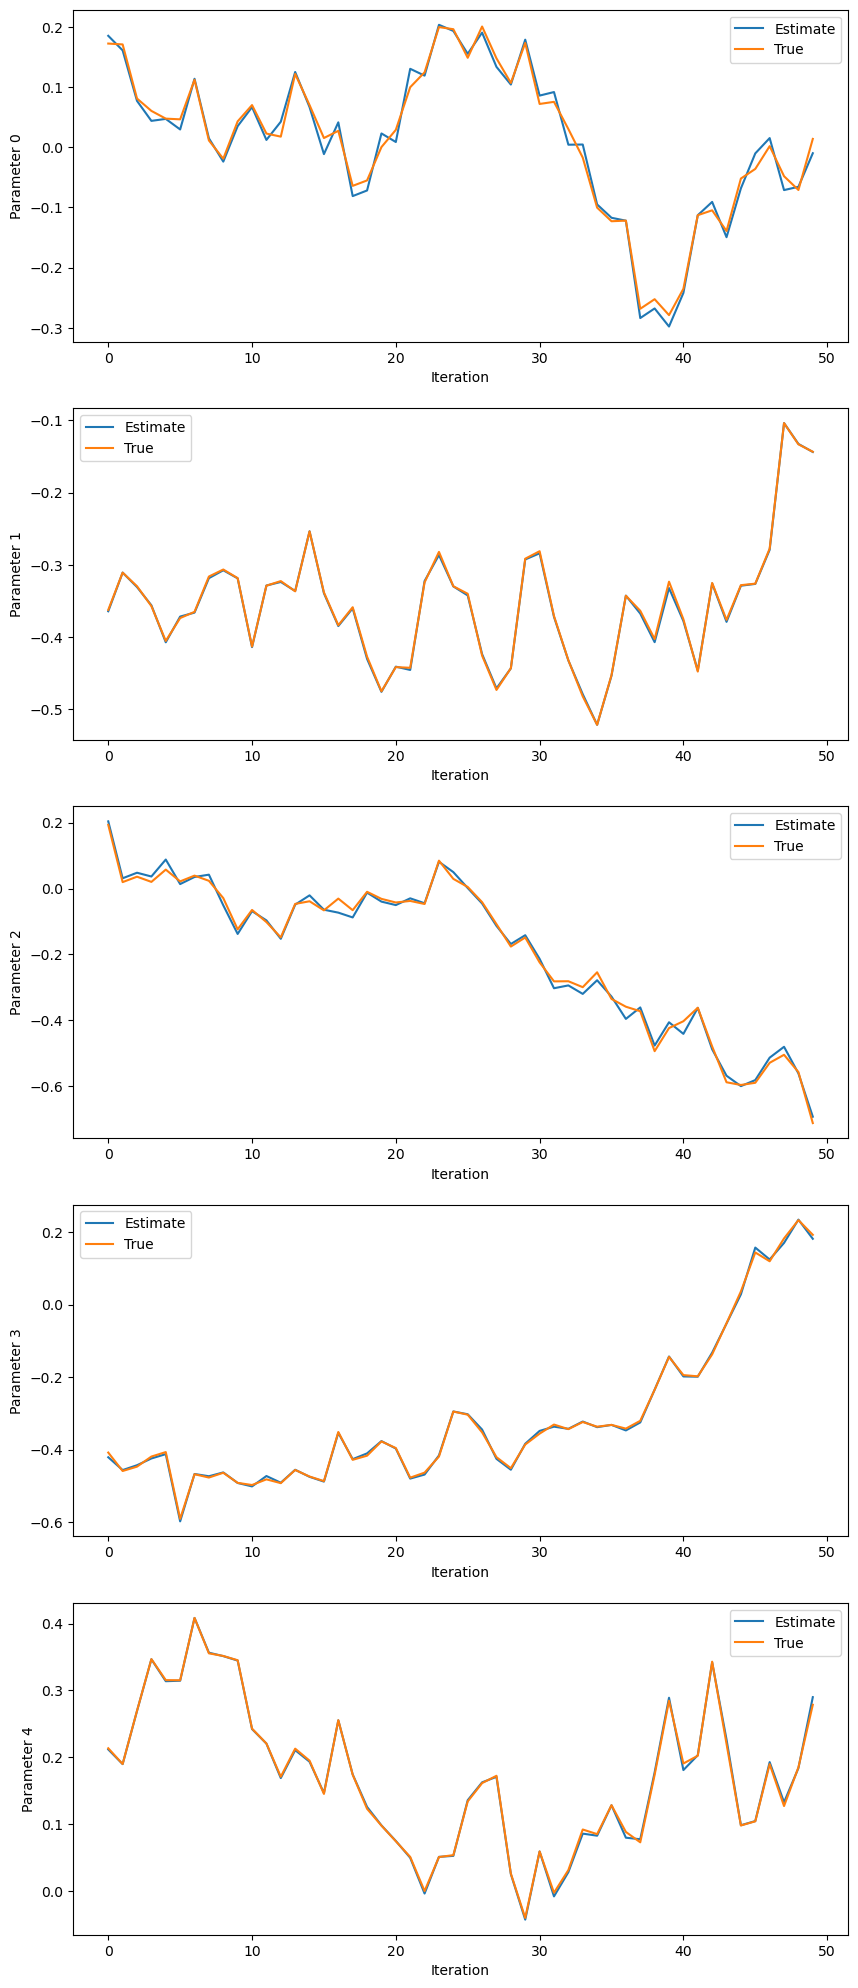

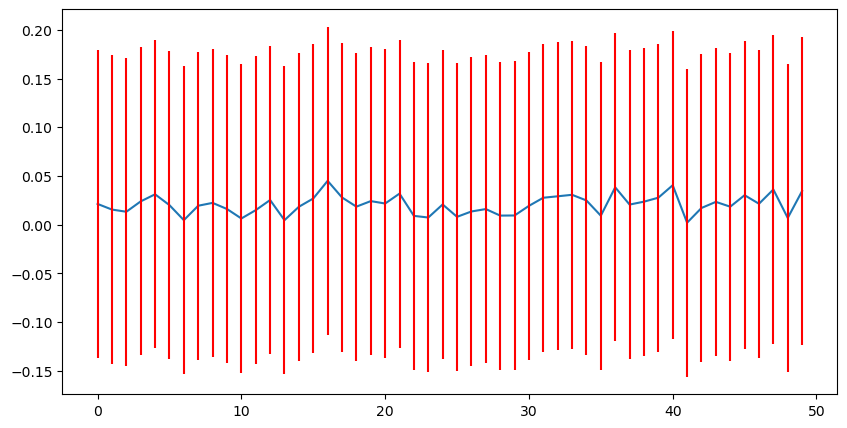

In [96]:
# plot all the evolutions
fig, axs = plt.subplots(5, 1, figsize=(10, 25))
for i in range(5):
    plot_evolution(ukf_history[:, i], true_state_history[:, i], ax=axs[i])
    axs[i].set_ylabel(f'Parameter {i}')
# plot the total error evolution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.linalg.norm(ukf_history - true_state_history, axis=1))
# plot error bars corresponding to the Q drift
ax.errorbar(np.arange(len(ukf_history)), np.linalg.norm(ukf_history - true_state_history, axis=1), yerr=np.sqrt(np.trace(Q)), fmt='none', ecolor='r')

Text(0, 0.5, 'Posterior Innovation Norm')

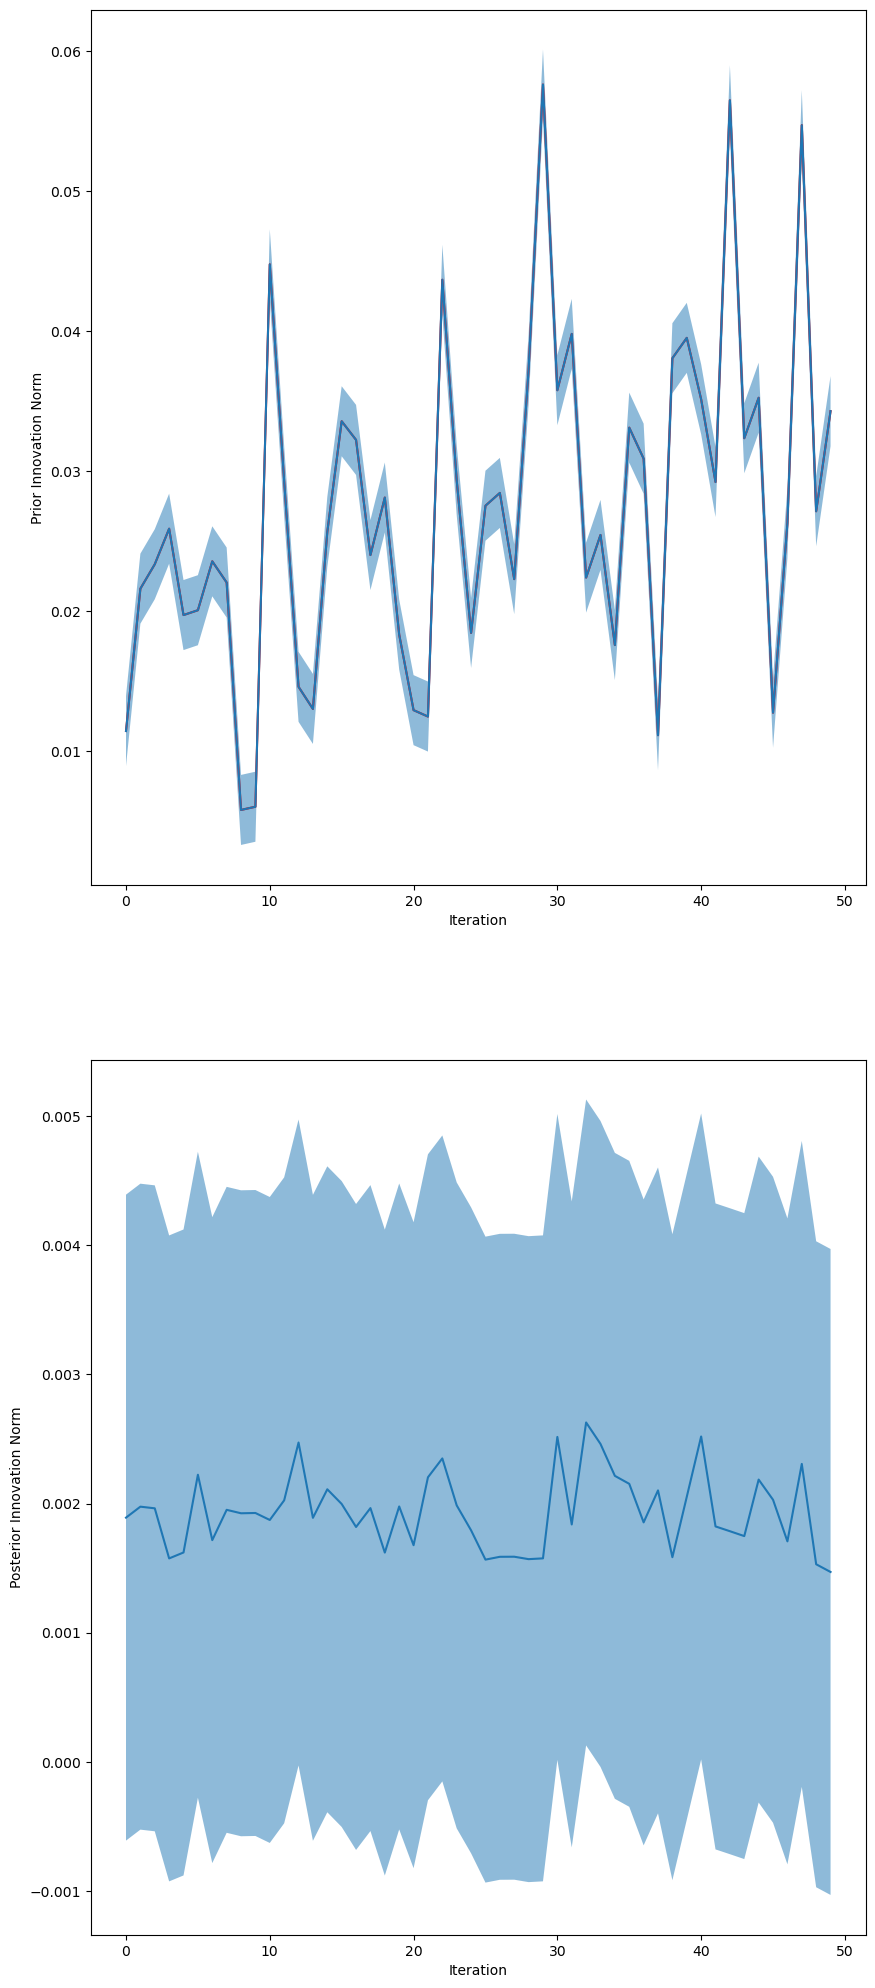

In [97]:
# plot the prior and posterior innovation norms
prior_innovation_history = np.array(prior_innovation_history)
posterior_innovation_history = np.array(posterior_innovation_history)
fig, axs = plt.subplots(2, 1, figsize=(10, 25))
observation_length = len(vector_from_dict(observations))
prior_innovation_history_scale = np.array(prior_innovation_history/observation_length)
posterior_innovation_history_scaled = np.array(posterior_innovation_history/observation_length)
std_error = np.sqrt(0.25/(num_shots*observation_length))
axs[0].fill_between(np.arange(len(prior_innovation_history_scale)), np.linalg.norm(prior_innovation_history_scale, axis=1) - std_error, np.linalg.norm(prior_innovation_history_scale, axis=1) + std_error, alpha=0.5)
axs[0].plot(np.arange(len(prior_innovation_history_scale)), np.linalg.norm(prior_innovation_history_scale, axis=1), color='r')
axs[0].plot(np.linalg.norm(prior_innovation_history_scale, axis=1))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Prior Innovation Norm')
std_error = np.sqrt(0.25/(num_shots*observation_length))
axs[1].fill_between(np.arange(len(posterior_innovation_history_scaled)), np.linalg.norm(posterior_innovation_history_scaled, axis=1) - std_error, np.linalg.norm(posterior_innovation_history_scaled, axis=1) + std_error, alpha=0.5)
axs[1].plot(np.linalg.norm(posterior_innovation_history_scaled, axis=1))
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Posterior Innovation Norm')



## tomographic estimation under drift (adapative edesign)

In [63]:
target_state = np.zeros(5)
covar = 0.001
true_state = target_state + np.random.normal(0, covar, 5)
x0 = target_state
P0 = np.eye(5)*covar
Q = np.eye(5)*0.01
num_shots = 1000

In [64]:
0.5*np.pi/np.sqrt(np.trace(P0+Q))

6.697898042428671

In [65]:
np.linalg.norm(true_state - x0)

0.002485424193589623

In [66]:

#ekf = KalmanFilter(x0, P0, Q=Q, record_history=True)
ukf = MyUKF(5, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.Q = Q

In [67]:
num_steps = 100
num_iterations = 10
tol = 1e-4

In [68]:
def step_state(x, Q):
    return x + np.random.multivariate_normal(np.zeros(5), Q)


In [69]:
from tqdm import tqdm

In [70]:
def vector_from_dict(d):
    # join the arrays in the dictionary into a single array
    return np.array([value for sublist in d.values() for value in sublist])

In [71]:
ukf_history = []
ekf_history = []
true_state_history = []
prior_innovation_history = []
posterior_innovation_history = []
observation_history = []
edesign = make_minimal_experiment_design(ukf.x, [1, 2, 4], 5, germ_list, all_state_preps, all_measurements)
for i in tqdm(range(num_steps)):
    true_state = step_state(true_state, Q)
    true_state_history.append(true_state)
    observations = edesign_observation(true_state, edesign, num_shots)
    observation_history.append(observations)
    prior_pred = edesign_probability(ukf.x, edesign)
    prior_innovation = vector_from_dict(observations)/num_shots - vector_from_dict(prior_pred)
    prior_innovation_history.append(prior_innovation)
    ukf.predict(u=np.zeros(5))
    ukf.update(observations, num_shots, num_iterations=num_iterations,tol=1e-5)
    post_pred = edesign_probability(ukf.x, edesign)
    posterior_innovation = vector_from_dict(observations)/num_shots - vector_from_dict(post_pred)
    posterior_innovation_history.append(posterior_innovation)
    ukf_history.append(ukf.x)
    if i%10 == 0:
        edesign = make_minimal_experiment_design(ukf.x, [1, 2, 4], 5, germ_list, all_state_preps, all_measurements)
        ukf.edesign = edesign
        
    # ekf.predict()
    # ekf.iterated_update(observations, edesign, 0.25/num_shots)
    #ekf_history.append(ekf.x)

 30%|███       | 30/100 [00:51<02:00,  1.72s/it]


KeyboardInterrupt: 

In [60]:
ukf_history = np.array(ukf_history)
#ekf_history = np.array(ekf_history)
true_state_history = np.array(true_state_history)

In [61]:
def plot_evolution(x, true_state_history, ax=None):
    if type(x) is list:
        x = np.array(x)
    if type(true_state_history) is list:
        true_state_history = np.array(true_state_history)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x[:], label='Estimate')
    ax.plot(true_state_history[:], label='True')
    ax.set_xlabel('Iteration')
    ax.legend()

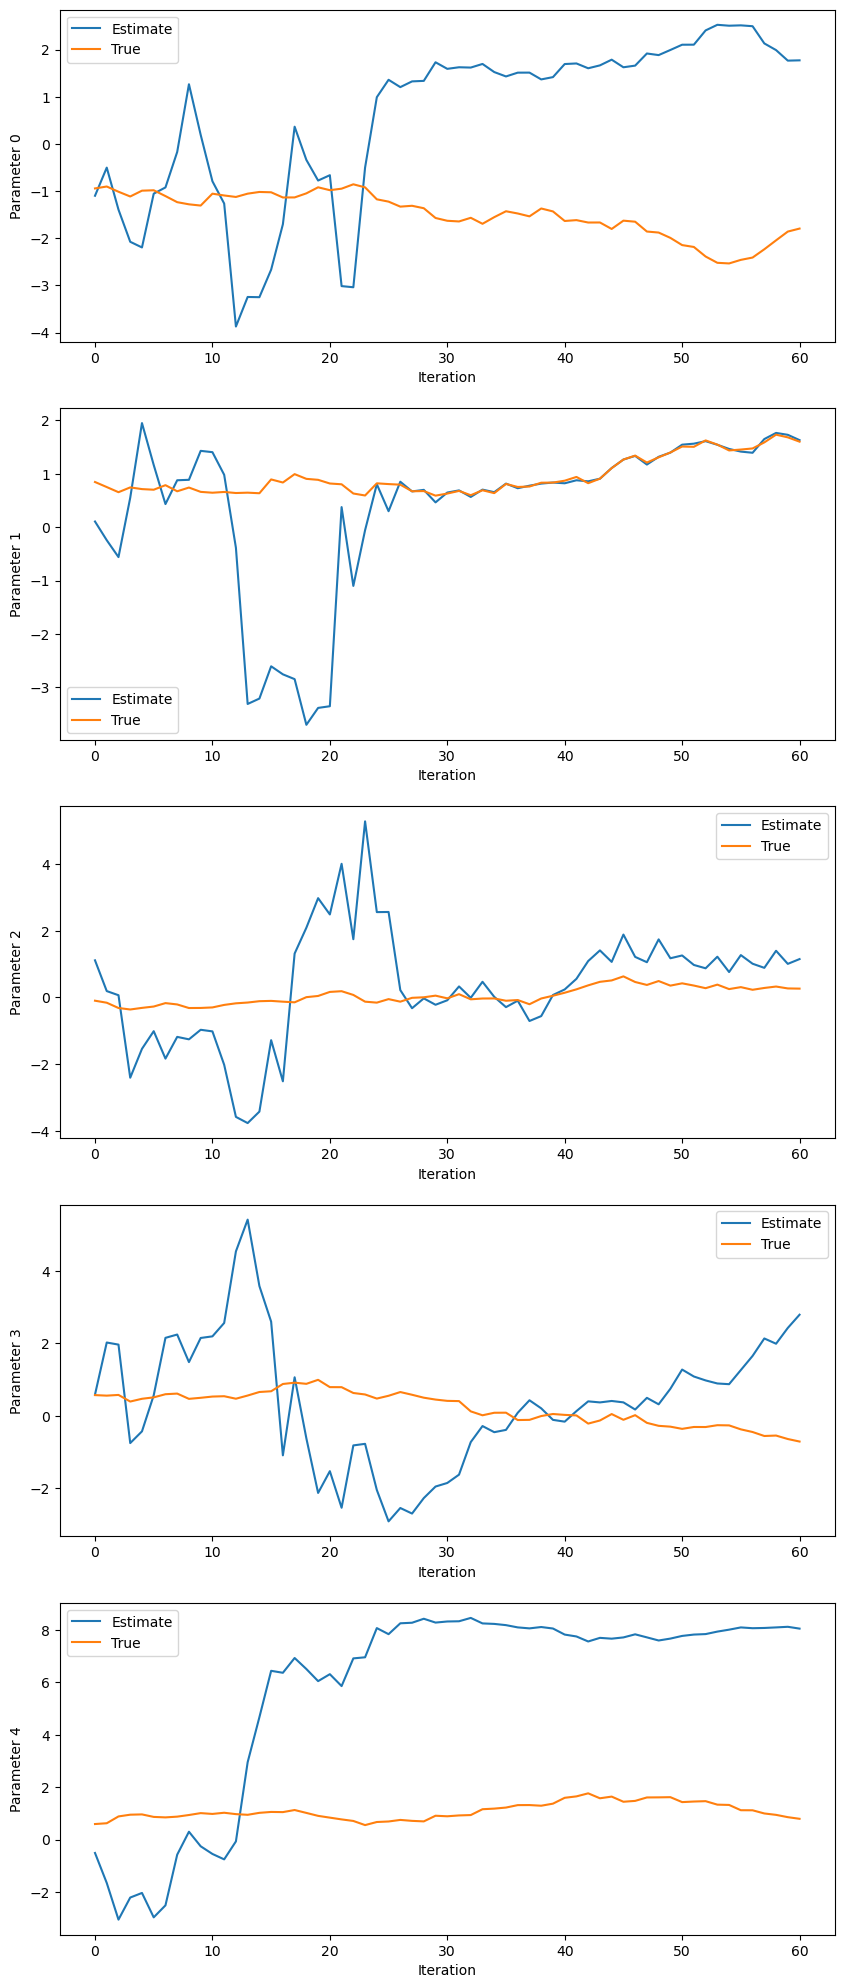

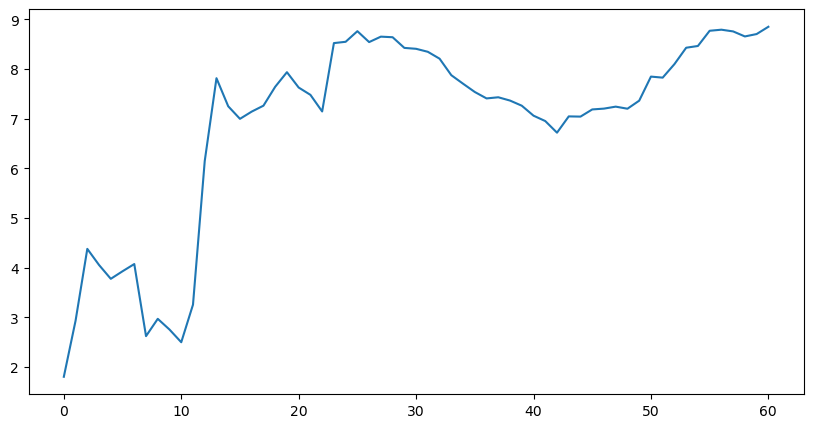

In [62]:
# plot all the evolutions
fig, axs = plt.subplots(5, 1, figsize=(10, 25))
for i in range(5):
    plot_evolution(ukf_history[:, i], true_state_history[:, i], ax=axs[i])
    axs[i].set_ylabel(f'Parameter {i}')
# plot the total error evolution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.linalg.norm(ukf_history - true_state_history, axis=1))

In [56]:
len(prior_innovation_history[-1])

15

In [58]:
len(prior_innovation_history[2])

15

In [52]:
# plot the prior and posterior innovation norms
prior_innovation_history = np.array(prior_innovation_history)
posterior_innovation_history = np.array(posterior_innovation_history)
fig, axs = plt.subplots(2, 1, figsize=(10, 25))
observation_length = len(vector_from_dict(observations))
prior_innovation_history_scale = np.array(prior_innovation_history/observation_length)
posterior_innovation_history_scaled = np.array(posterior_innovation_history/observation_length)
std_error = np.sqrt(0.25/(num_shots*observation_length))
axs[0].fill_between(np.arange(len(prior_innovation_history_scale)), np.linalg.norm(prior_innovation_history_scale, axis=1) - std_error, np.linalg.norm(prior_innovation_history_scale, axis=1) + std_error, alpha=0.5)
axs[0].plot(np.arange(len(prior_innovation_history_scale)), np.linalg.norm(prior_innovation_history_scale, axis=1), color='r')
axs[0].plot(np.linalg.norm(prior_innovation_history_scale, axis=1))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Prior Innovation Norm')
std_error = np.sqrt(0.25/(num_shots*observation_length))
axs[1].fill_between(np.arange(len(posterior_innovation_history_scaled)), np.linalg.norm(posterior_innovation_history_scaled, axis=1) - std_error, np.linalg.norm(posterior_innovation_history_scaled, axis=1) + std_error, alpha=0.5)
axs[1].plot(np.linalg.norm(posterior_innovation_history_scaled, axis=1))
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Posterior Innovation Norm')



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (61,) + inhomogeneous part.

## Control Model

Three control knobs, correspond to changes in the frequency, drive strength, and phase offset

The usual control model is 
$$
    X(a, b, c) = \exp(-\frac{i}{2}( \eta a \sigma_z + \omega b \sigma_x))
$$
$$
    Y(a, b, c) = \exp(-\frac{i}{2}( \eta a \sigma_z + \omega b (\cos(c) \sigma_x + \sin(c) \sigma_y)))
$$


$$
    x_{k+1} \approx x_k + B[x_k] u_k
$$
where 
$$
    B[x_k] = \begin{bmatrix}
    \eta & 0 & 0 & 0 & 0 \\
    0 & \omega & 0 & 0 & 0\\
    0 & 0 & \eta & 0 & 0 \\
    0 & 0 & 0 & \omega \cos \varphi & \omega \sin \varphi \\
    0 & 0 & 0 & - A \sin \varphi & A \cos \varphi 
    \end{bmatrix}^T
$$
where
$$
    \varphi = \arctan(x[4]+\pi/2, x[3])
$$
$$
    A = \sqrt{x[3]^2 + (x[4]+\pi/2)^2}
$$


In [199]:
def make_B(xstate, eta, omega):
    phi = np.arctan2(xstate[4] + np.pi/2, xstate[3])
    A = np.sqrt(xstate[3]**2 + (xstate[4] + np.pi/2)**2)
    B = np.zeros((5, 5))
    B[0, 0] = eta
    B[1, 1] = omega 
    B[2, 2] = eta 
    B[3, 3] = omega*np.cos(phi) 
    B[3, 4] = -A*np.sin(phi)
    B[4, 3] = omega*np.sin(phi)
    B[4, 4] = A*np.cos(phi)
    return B.T

In [200]:
def make_lqr_gain(A, B, Q, R):
    """Solve the continuous time lqr controller."""
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R + B.T@P@B)*B.T@P@A)
    return K

In [201]:
covar = 0.001
P0 = np.eye(5)*covar
Q = np.eye(5)*0.001
0.5*np.pi/np.sqrt(np.trace(P0+Q))

15.707963267948966

In [202]:
depths = [1, 2, 4, 8]
num_circ_per_depth = 10
edesign = make_minimal_experiment_design(target_state, depths, num_circ_per_depth, germ_list, all_state_preps, all_measurements)

### start experiment

In [221]:
target_state = np.zeros(5)

true_state = target_state + np.random.multivariate_normal(np.zeros(5), P0)
x0 = target_state

num_shots = 1000
num_steps = 50


In [222]:
#ekf = KalmanFilter(x0, P0, Q=Q, record_history=True)
ukf = MyUKF(5, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.Q = Q

In [223]:
A = np.eye(5)
Q_lqr = np.diag([1, 1, 1, 1, 1])
R_lqr = np.diag([0.1, 0.1, 0.1, 0.1, 10])

In [224]:

num_iterations = 10
tol = 1e-4

In [225]:
ukf_history = []
ekf_history = []
true_state_history = []
prior_innovation_history = []
posterior_innovation_history = []
observation_history = []
ukf.predict(u=np.zeros(5))
unregulated_history = []
for i in tqdm(range(num_steps)):
    w = np.random.multivariate_normal(np.zeros(5), Q)
    true_state = true_state + w
    if i == 0:
        unregulated_history.append(true_state)
    else:
        unregulated_history.append(unregulated_history[-1] + w)
    true_state_history.append(true_state)
    observations = edesign_observation(true_state, edesign, num_shots)
    observation_history.append(observations)
    prior_pred = edesign_probability(ukf.x, edesign)
    prior_innovation = vector_from_dict(observations)/num_shots - vector_from_dict(prior_pred)
    prior_innovation_history.append(prior_innovation)

    ukf.update(observations, num_shots, num_iterations=num_iterations,tol=1e-5)
    post_pred = edesign_probability(ukf.x, edesign)
    posterior_innovation = vector_from_dict(observations)/num_shots - vector_from_dict(post_pred)
    posterior_innovation_history.append(posterior_innovation)
    ukf_history.append(ukf.x)

    # "make a control update"
    B = make_B(ukf.x, 1, 1)
    gain = make_lqr_gain(A, B, Q_lqr, R_lqr)
    u = - np.array(gain.dot(ukf.x - target_state)).flatten()
    true_state = true_state  + B@u
    ukf.predict(u=B@u)

    # ekf.predict()
    # ekf.iterated_update(observations, edesign, 0.25/num_shots)
    #ekf_history.append(ekf.x)

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


In [226]:
ukf_history = np.array(ukf_history)
#ekf_history = np.array(ekf_history)
true_state_history = np.array(true_state_history)
unregulated_history = np.array(unregulated_history)

<ErrorbarContainer object of 3 artists>

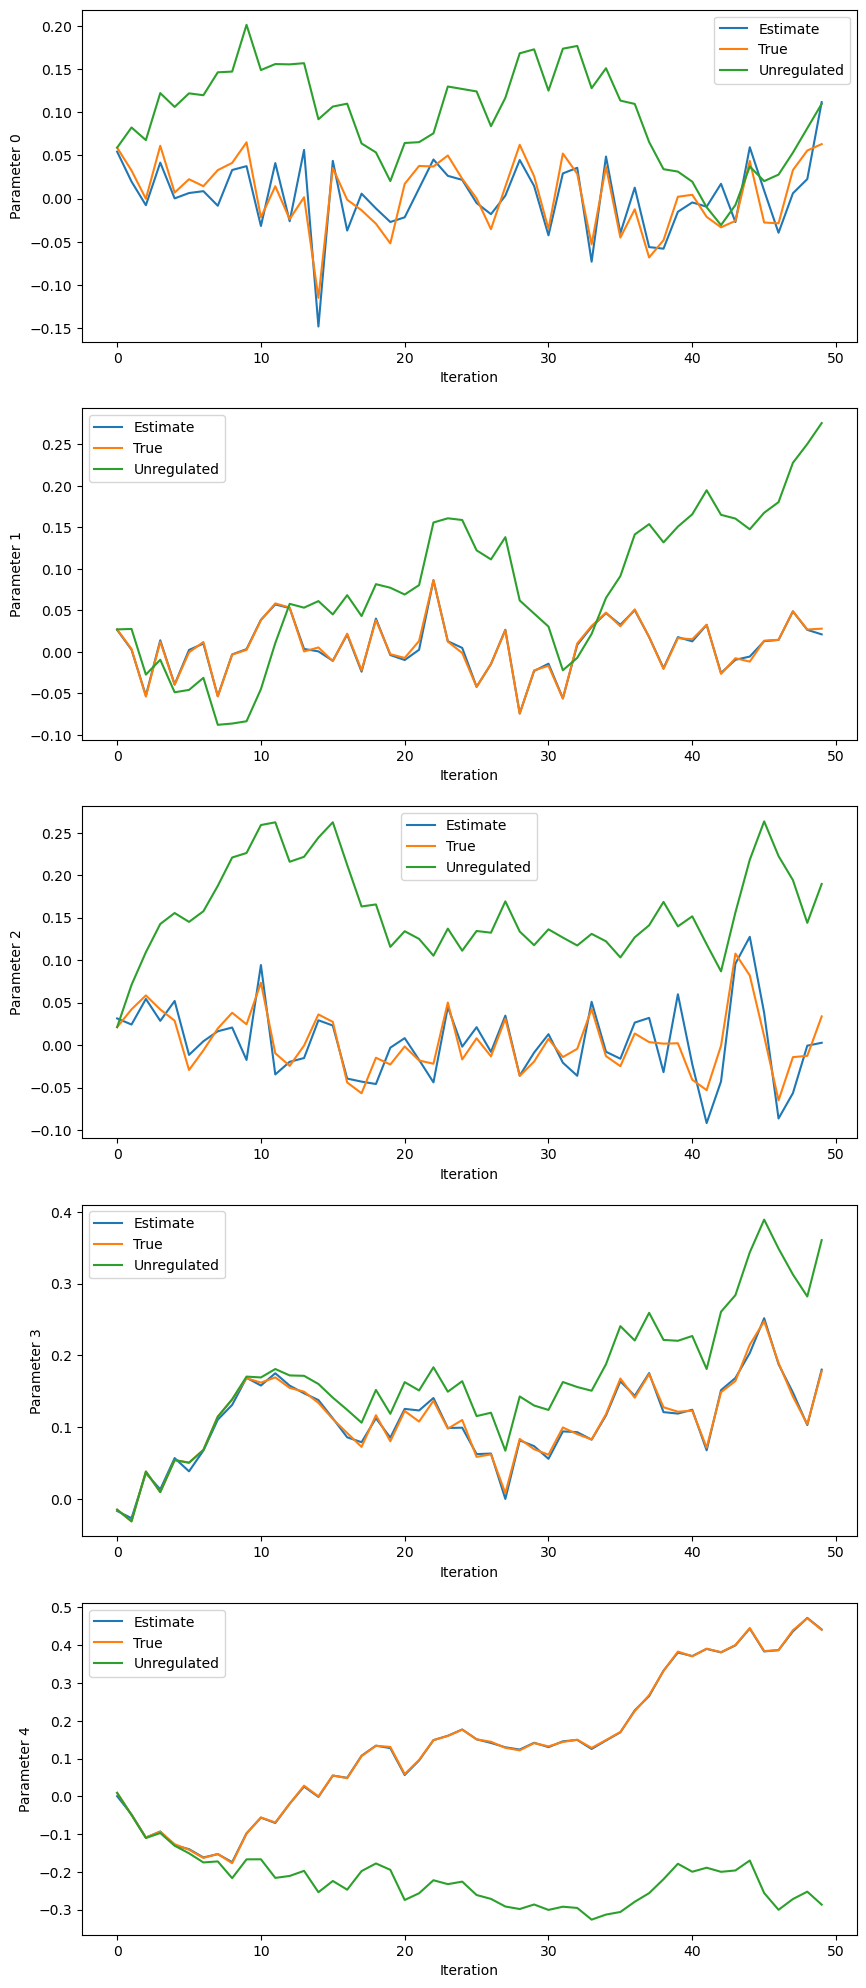

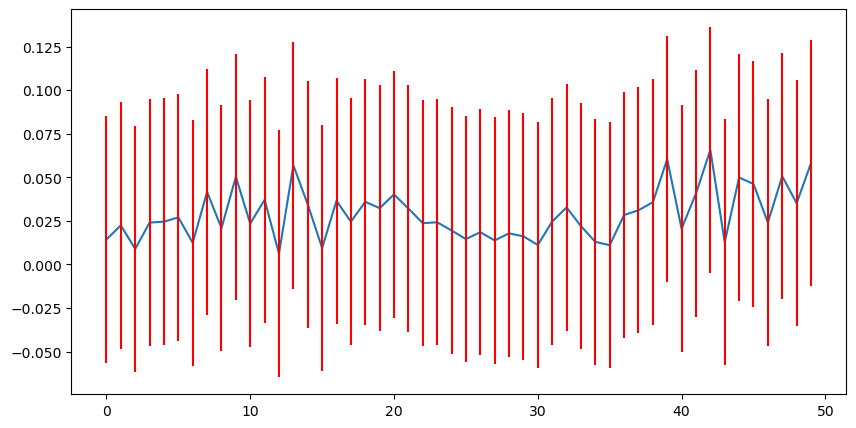

In [227]:
# plot all the evolutions
fig, axs = plt.subplots(5, 1, figsize=(10, 25))
for i in range(5):
    plot_evolution(ukf_history[:, i], true_state_history[:, i], ax=axs[i])
    axs[i].set_ylabel(f'Parameter {i}')
    # also plut the unregulated evolution
    axs[i].plot(unregulated_history[:num_steps, i], label='Unregulated')
    axs[i].legend()
# plot the total error evolution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.linalg.norm(ukf_history - true_state_history, axis=1))
# plot error bars corresponding to the Q drift
ax.errorbar(np.arange(len(ukf_history)), np.linalg.norm(ukf_history - true_state_history, axis=1), yerr=np.sqrt(np.trace(Q)), fmt='none', ecolor='r')

Text(0, 0.5, 'Posterior Innovation Norm')

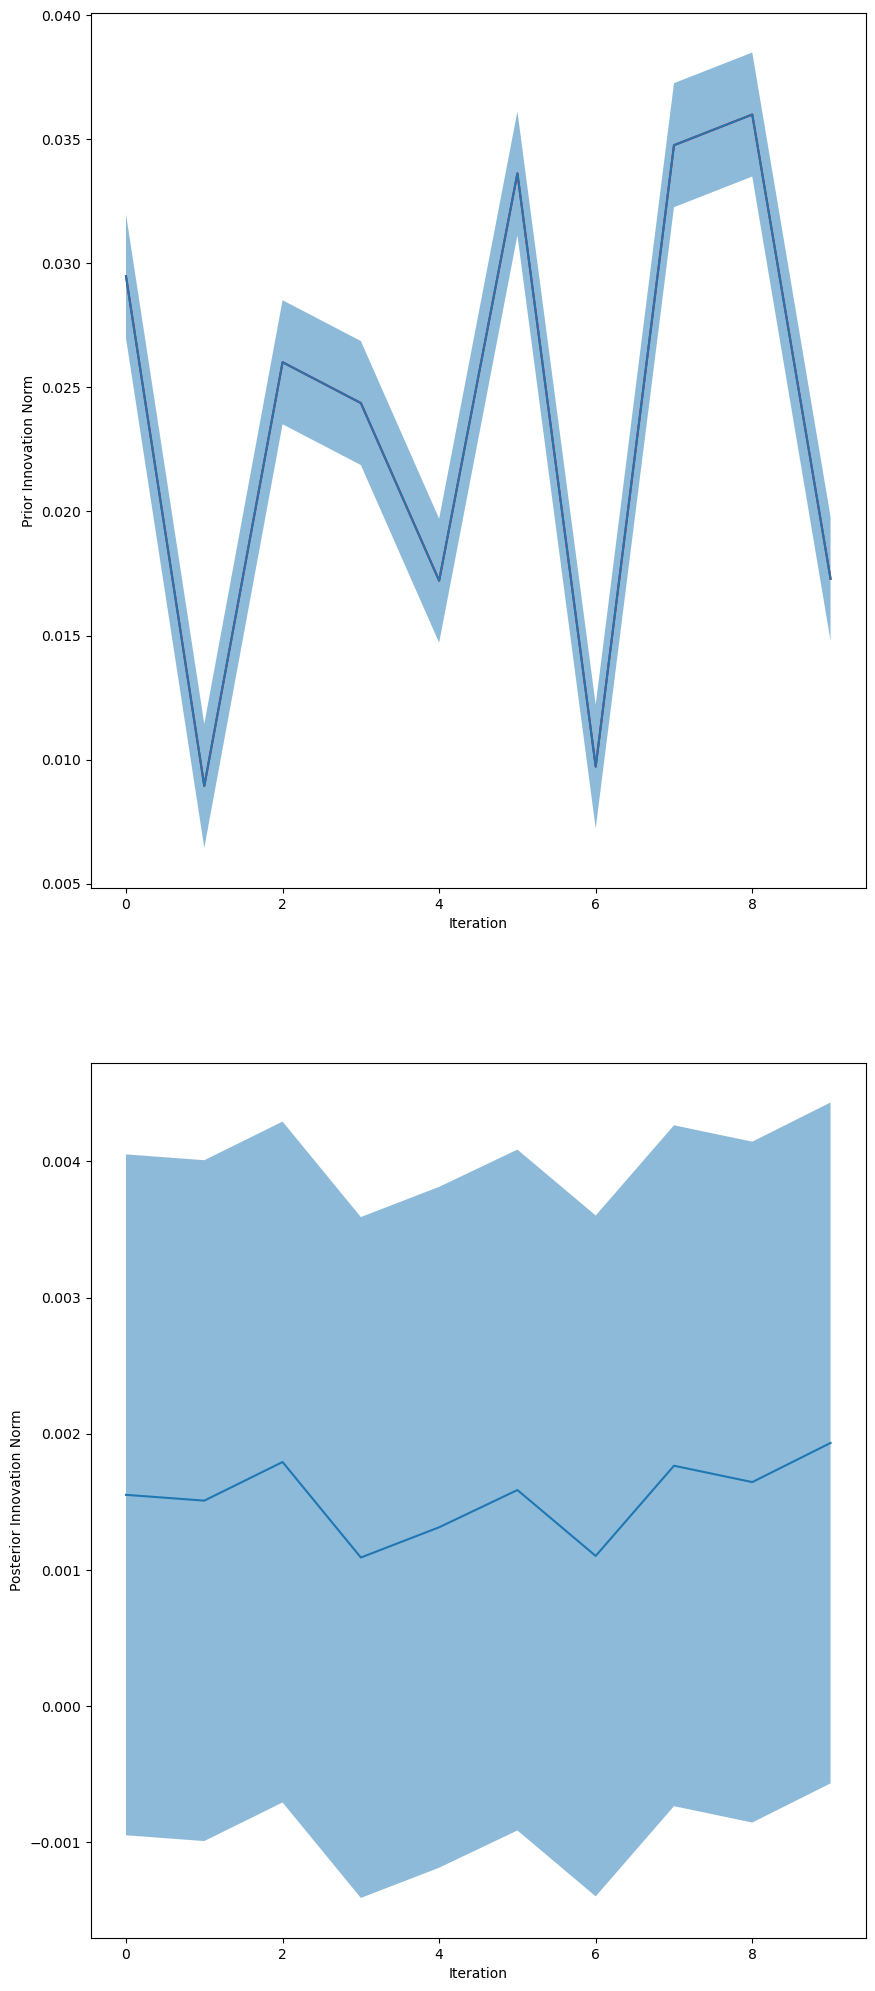

In [184]:
# plot the prior and posterior innovation norms
prior_innovation_history = np.array(prior_innovation_history)
posterior_innovation_history = np.array(posterior_innovation_history)
fig, axs = plt.subplots(2, 1, figsize=(10, 25))
observation_length = len(vector_from_dict(observations))
prior_innovation_history_scale = np.array(prior_innovation_history/observation_length)
posterior_innovation_history_scaled = np.array(posterior_innovation_history/observation_length)
std_error = np.sqrt(0.25/(num_shots*observation_length))
axs[0].fill_between(np.arange(len(prior_innovation_history_scale)), np.linalg.norm(prior_innovation_history_scale, axis=1) - std_error, np.linalg.norm(prior_innovation_history_scale, axis=1) + std_error, alpha=0.5)
axs[0].plot(np.arange(len(prior_innovation_history_scale)), np.linalg.norm(prior_innovation_history_scale, axis=1), color='r')
axs[0].plot(np.linalg.norm(prior_innovation_history_scale, axis=1))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Prior Innovation Norm')
std_error = np.sqrt(0.25/(num_shots*observation_length))
axs[1].fill_between(np.arange(len(posterior_innovation_history_scaled)), np.linalg.norm(posterior_innovation_history_scaled, axis=1) - std_error, np.linalg.norm(posterior_innovation_history_scaled, axis=1) + std_error, alpha=0.5)
axs[1].plot(np.linalg.norm(posterior_innovation_history_scaled, axis=1))
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Posterior Innovation Norm')



In [ ]:
state_history = []
ukf_history = []
state = step_state(target_state, Q)
state_history.append(state)
unregulated_history = [state]
ukf.predict()
for i in tqdm(range(num_steps)):
    if i % 3 == 0:
        edesign = make_minimal_experiment_design(state, [1, 2, 4], 4, germ_list, all_state_preps, all_measurements)
        ukf.edesign = edesign
    observations = edesign_observation(state, edesign, num_shots)
    
    ukf.update(observations, num_shots, num_iters=num_iters, tol=tol)
    ukf_history.append(ukf.x)
    
    w = np.random.multivariate_normal(np.zeros(3), Q)
    state = state + w
    state = np.unwrap(state)
    unregulated_history.append(unregulated_history[-1] + w)
    state_history.append(state)
    # "make a control update"
    B = make_B(ukf.x, 1, 1)
    gain = make_lqr_gain(A, B, Q_lqr, R_lqr)
    u = - np.array(gain.dot(ukf.x - target_state)).flatten()
    state = state  + u
    ukf.predict(u=u)